# Experimental Holography
In this notebook, we:
- Connect to an SLM and a camera.
- Produce and view a simple hologram.
- Calibrate the relationship between the coordinate spaces of the camera and the SLM using a Fourier calibration.
- TODO: finish list

TODO: Add an image about how the components are placed physically.

In [1]:
# Header.

# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys, time
import numpy as np
import cv2
import scipy.ndimage as ndimage

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('image', cmap='Blues')

# Add slmsuite to the python path. TODO: Remove and replace with package import
sys.path.append(os.path.join(os.getcwd(), '../../..'))

from slmsuite.holography import analysis, toolbox
from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras import AlliedVision
from slmsuite.hardware.cameraslms import FourierSLM
from slmsuite.holography.algorithms import FeedbackHologram, SpotHologram

screenmirrored.py: pyglet not installed. Install to use ScreenMirrored SLMs.
filr.py: PySpin not installed. Install to use FLIR cameras.
thorlabs.py: thorlabs_tsi_sdk not installed. Install to use Thorlabs cameras.


#### Loading Hardware

**Cameras** and **SLMs** are connected to python by a myriad of SDKs, often provided by hardware
vendors. However, these SDKs likewise have a myriad of function names and hardware-specific
quirks. Thus, hardware in `slmsuite` is integrated as subclasses of
the abstract classes `.Camera` and `.SLM`.
These subclasses for [cameras](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameras.html) 
and [slms](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.slms.html)
are effectively wrappers for given SDKs, implemented with standardized methods and syntax that the rest of `slmsuite` can understand, but also include
quality-of-life features.
If you believe your camera or SLM is not supported by the currently available classes, please 
[open a GitHub issue](https://github.com/QPG-MIT/slmsuite/issues) 
or [feel free to write an interface yourself](https://github.com/QPG-MIT/slmsuite/blob/main/CONTRIBUTING.md)!

First, let's load an SLM. We're running this notebook with a `Santec` SLM.
We can find connected displays with the `.info()` static method.

In [2]:
from slmsuite.hardware.slms.santec import Santec
Santec.info(verbose=True);

Displays detected by Santec
display_number, display_name:
1,  HP S2231,HWP,2905,3CQ02001CN
2,  LCOS-SLM,SOC,8001,2018021001


We see that `display_number=2` is the display with the LCoS SLM. We're running this setup with a 633 nm HeNe laser. All functions are documented, including the below 
[initializer](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.slms.santec.Santec.html#slmsuite.hardware.slms.santec.Santec.__init__).

In [3]:
slm = Santec(slm_number=1, display_number=2, wav_um=.633)

Santec slm_number=1 initializing... success
Looking for display_number=2... success
Opening LCOS-SLM,SOC,8001,2018021001... success


Next, let's load a camera. We're running this notebook with a `AlliedVision` camera. We can find connected cameras with the `.info()` static method.

In [4]:
from slmsuite.hardware.cameras.alliedvision import AlliedVision
AlliedVision.info(verbose=True);

AlliedVision serials:
"02C5V"
"08-406808001844"


We want the `"02C5V"` serial.

In [5]:
cam = AlliedVision(serial="02C5V", verbose=True)

vimba initializing... success
Looking for cameras... success
vimba sn 02C5V initializing... success


Lastly, we'll make a [class for our composite optical system](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameraslms.FourierSLM.html#slmsuite.hardware.cameraslms.FourierSLM), 
consisting of the camera and the SLM. We'll also load a previously-measured 
[wavefront calibration](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameraslms.FourierSLM.html#slmsuite.hardware.cameraslms.FourierSLM.wavefront_calibrate)
(we'll come back to this!).

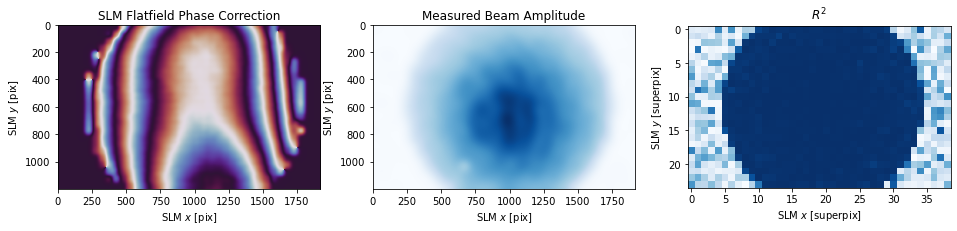

In [6]:
from slmsuite.hardware.cameraslms import FourierSLM
fs = FourierSLM(cam, slm)
fs.load_wavefront_calibration(plot=True);    # We'll come back to this!

#### Simple Holography

Let's start out with the simplest phase pattern possible: no pattern! We 
[write](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.slms.slm.SLM.html#slmsuite.hardware.slms.slm.SLM.write) 
a flat phase $\phi(\vec{x}) = 0\pi$ to the SLM with `.write()`.

In [7]:
phase = np.zeros(slm.shape)
slm.write(phase, settle=True);      # slm.write(None, settle=True) is equivalent to this.

Great. Let's [take a look](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameras.camera.Camera.html#slmsuite.hardware.cameras.camera.Camera.get_image)
at the result in our camera with `.get_image()`. We'll also set the exposure to an appropriate value.

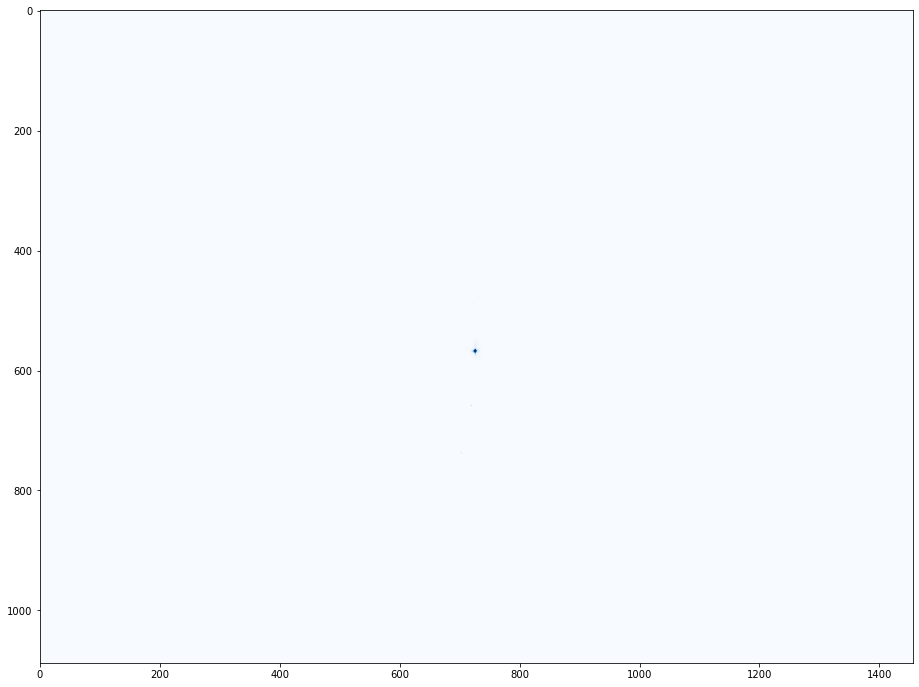

In [8]:
cam.set_exposure(.0002)
img = cam.get_image()

# Plot the result
plt.figure(figsize=(24, 12))
plt.imshow(img)
plt.show()

As expected, we see a spot corresponding to the zero-th order diffraction peak. This spot is focussed at the center of our camera.

We're going to be `.write()`ing phases and `.get`ing`_image()`s a couple more times in this notebook, so we'll define a method `plot_phase()` to help us with that.

In [9]:
def plot_phase(phase, title="", zoom=True):
    # One plot if no camera; two otherwise.
    _, axs = plt.subplots(1, 2 - (cam is None), figsize=(24,6))

    if cam is None:
        axs = [axs]
    
    # Plot the phase.
    axs[0].set_title("SLM Phase")
    im = axs[0].imshow(
        np.mod(phase, 2*np.pi), 
        vmin=0,
        vmax=2*np.pi, 
        interpolation="none", 
        cmap="twilight"
    )
    plt.colorbar(im, ax=axs[0])
    
    # Grab an image of the resulting pattern and plot.
    slm.write(phase, settle=True)
    img = cam.get_image()

    axs[1].set_title("Camera Result")
    axs[1].imshow(img)
    if zoom:
        xlim = axs[1].get_xlim()
        ylim = axs[1].get_ylim()
        axs[1].set_xlim([xlim[0] * .7 + xlim[1] * .3, xlim[0] * .3 + xlim[1] * .7])
        axs[1].set_ylim([ylim[0] * .7 + ylim[1] * .3, ylim[0] * .3 + ylim[1] * .7])

    # Make a title, if given.
    plt.suptitle(title)
    plt.show()

Next, we'll move the laser spot by applying a 
[blazed grating](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.blaze.html#slmsuite.holography.toolbox.blaze)
to the SLM using a helper function from our `toolbox`. This blazed grating has a Fourier spectrum shifted from the origin, so naturally applying this pattern to the SLM will produce a shifted result in the farfield, i.e. in the plane of the camera.

Many common phases patterns are available in the `slmsuite.holography.toolbox`. See the Structured Light example for more information (e.g. the behavior of `grid=`).

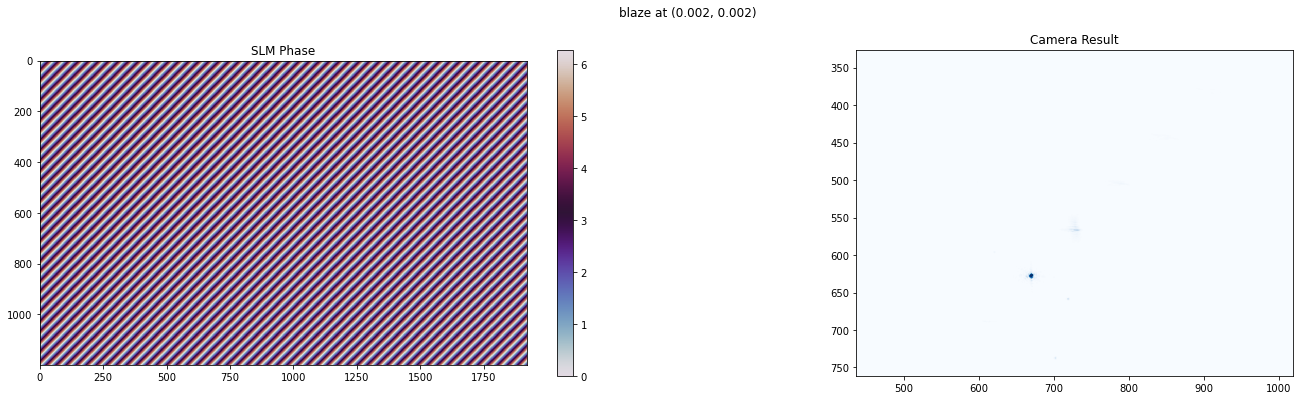

In [10]:
from slmsuite.holography import toolbox

vector = (.002, .002)   # Radians (== normalized units kx/k)
blaze_phase = toolbox.blaze(grid=slm, vector=vector)
plot_phase(blaze_phase, title="blaze at {}".format(vector))

But what units does `vector` have? The default blaze units in `slmsuite` (`"norm"`) are normalized $k_x/k$ units, which are equivalent to radians in the small angle approximation. To get a better handle on what `vector = (.002, .002)` means, we can 
[print](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.print_blaze_conversions.html#slmsuite.holography.toolbox.print_blaze_conversions)
the equivalent vectors converted to supported units with `toolbox.print_blaze_conversions()`.

In [11]:
toolbox.print_blaze_conversions(vector=(.002, .002), from_units="norm", slm=slm)

'norm' : (0.002, 0.002)
'kxy' : (0.002, 0.002)
'knm' : (1008.5308056872038, 630.3317535545024)
'freq' : (0.02527646129541864, 0.02527646129541864)
'lpmm' : (3.1595576619273302, 3.1595576619273302)
'rad' : (0.002, 0.002)
'mrad' : (2.0, 2.0)
'deg' : (0.11459155902616464, 0.11459155902616464)


Okay. So this means that we're diffracting light by an angle of two miliradians or a tenth of a degree.
Of course, all the units are [documented](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.convert_blaze_vector.html#slmsuite.holography.toolbox.convert_blaze_vector).

This function wraps `toolbox.convert_blaze_vector()` which handles arbitrary unit conversions. Let's try it out by diffracting light at .2 degrees in the $x$ and $y$ directions.

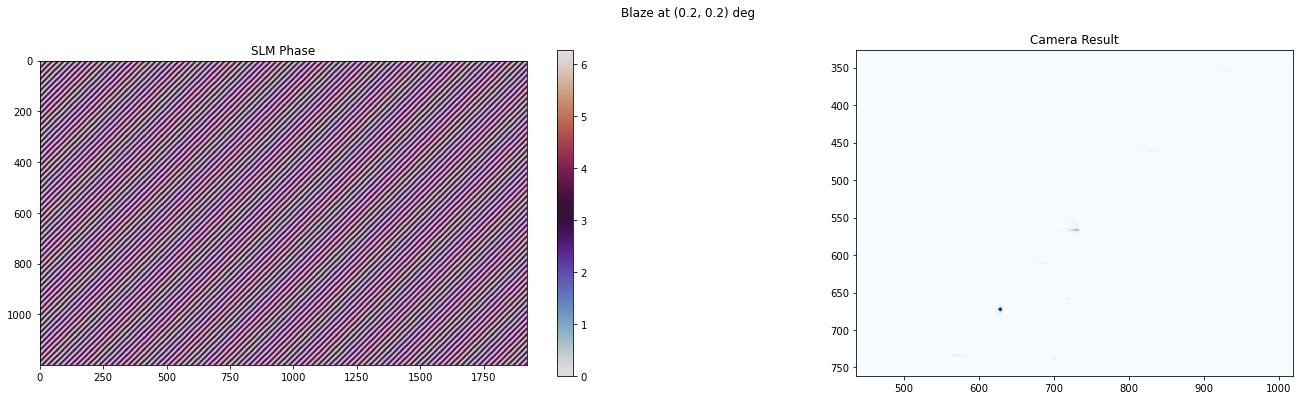

In [12]:
vector_deg = (.2, .2)
vector = toolbox.convert_blaze_vector(vector_deg, from_units="deg", to_units="norm")
blaze_phase = toolbox.blaze(grid=slm, vector=vector)
plot_phase(blaze_phase, title="Blaze at {} deg".format(vector_deg))

All this is good fun, but let's say we wanted our spot right at pixel `(600, 600)`. We could iterate by guessing and checking successive `vectors`, but that seems boring and non-pythonic. Instead, we will calibrate a transformation between the $k$-space of the SLM and the space of the camera using features built-in to `slmsuite`.

#### Fourier Calibration

Calibration is simple, just run a built-in function `.fourier_calibrate()` to 1) generate and 2) fit a grid of spots (with known $k$-space coordinates) with an affine transformation to the space of the camera. This grid is generated using 
[techniques](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.algorithms.html)
that we'll discuss later. Care must be taken to choose:

 - A camera exposure such that spots are prominent,
 - A pitch and shape of the array which are visible.

Note that the default array units are in `"knm"` space, or the 
[computational space of holography](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.algorithms.html). 
Read more about this in later examples.

100%|██████████| 50/50 [00:00<00:00, 76.29it/s]


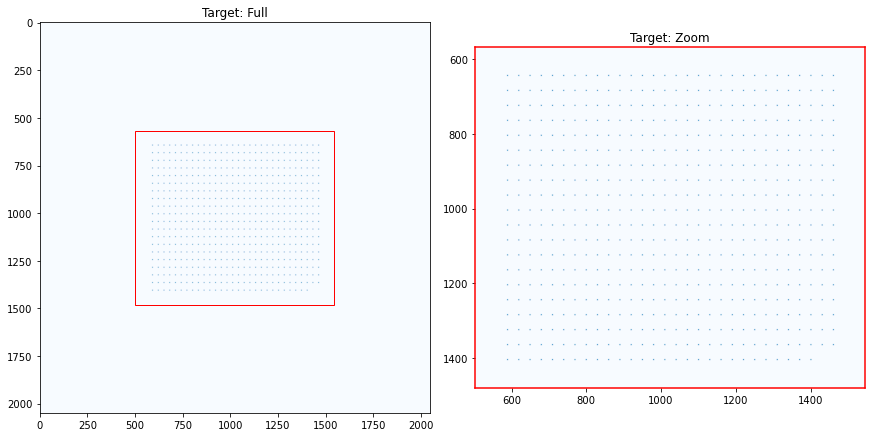

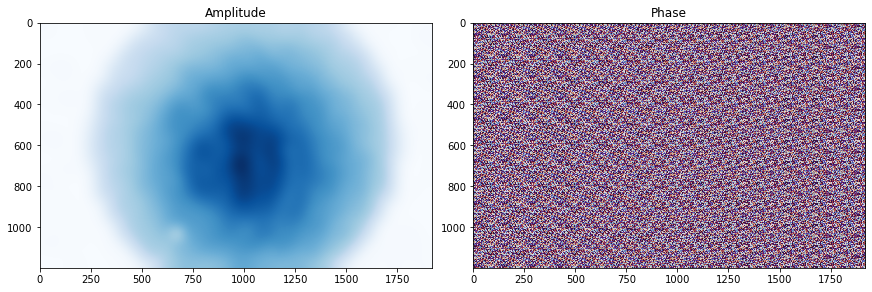

index 1088 is out of bounds for axis 0 with size 1088


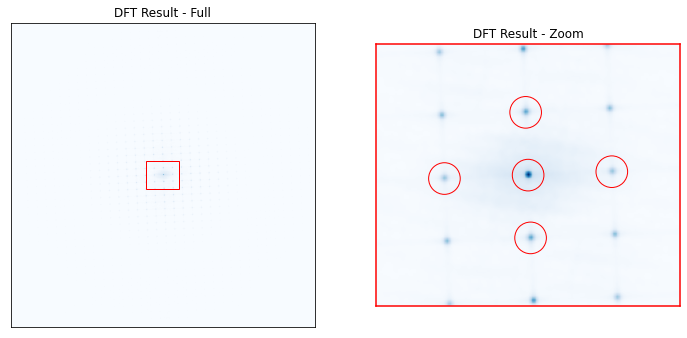

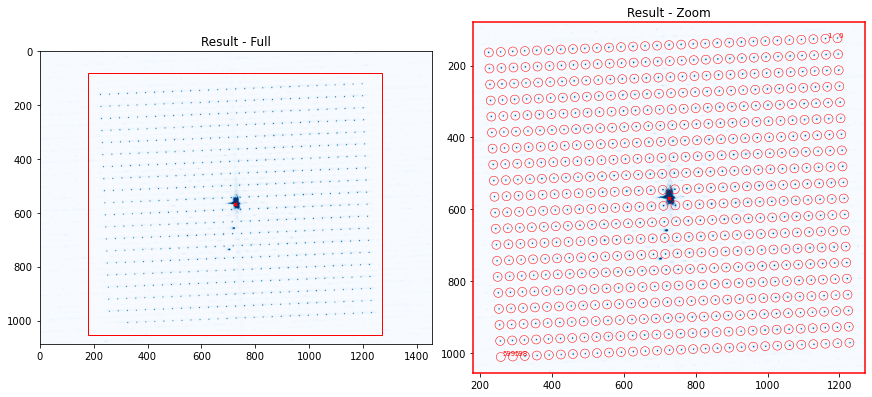

In [13]:
cam.set_exposure(.05)               # Increase exposure because power will be split many ways

fs.fourier_calibrate(
    array_shape=[30, 20],           # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=[30, 40],           # Pitch of the calibration grid (x, y) [knm]
    plot=True
)

cam.set_exposure(.0002)             # Restore exposure

Notice that there are two missing spots from the array. This is a parity check to make sure the calibration is flipped in the correct direction.

The result of this process is the transformation

$\vec{x} = M \cdot (\vec{k} - \vec{a}) + \vec{b}$

where $\vec{x}$ is in units of camera pixels and $\vec{k}$ is in units of normalized $k$-space. We can view the result in the `fourier_calibration` variable.

In [14]:
fs.fourier_calibration

{'M': array([[-28876.09736229,   1132.92238856],
        [  1181.73152374,  28874.45488851]]),
 'b': array([[726. ],
        [567.5]]),
 'a': array([[-5.42702563e-05],
        [-4.91016605e-05]])}

Now let's use this calibration to achieve our goal of `(600, 600)`. We can find the blaze vector $\vec{k}$ (in normalized units) corresponding to the desired pixel $\vec{x}$ using our calibration.

In [15]:
vector_600_600 = fs.ijcam_to_kxyslm((600, 600))
print(vector_600_600)

[[0.00434629]
 [0.00089636]]


Now let's check this result:

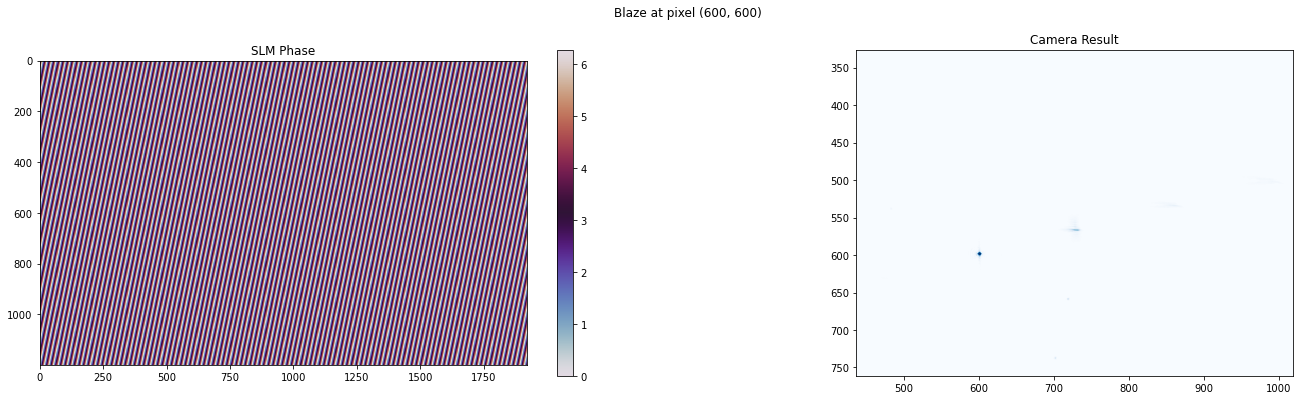

In [16]:
blaze_phase = toolbox.blaze(grid=slm, vector=vector_600_600)
plot_phase(blaze_phase, title="Blaze at pixel (600, 600)")